### Looking at the Medical Segmentation Dataset and their approach to lung segementation 

In [2]:
#Importing necessary packages
# Packages from __main__
import sys
import argparse
import logging
from lungmask import mask
from lungmask import utils
import os
import SimpleITK as sitk

#ResUNet Packages:
import torch
from torch import nn
import torch.nn.functional as F

# Packages from mask.py 
import numpy as np
import SimpleITK as sitk
#from .resunet import UNet
import warnings
import sys
from tqdm import tqdm
import logging


import nbconvert
import os
from glob import glob

from matplotlib import pyplot as plt
%matplotlib inline
from scipy import ndimage
import gzip
import nibabel as nib

#### Unzipping Images and printing out some examples

Image dimensions: (512, 512, 100)
Voxel Size: (1.0, 1.0, 1.0)


(-0.5, 511.5, 511.5, -0.5)

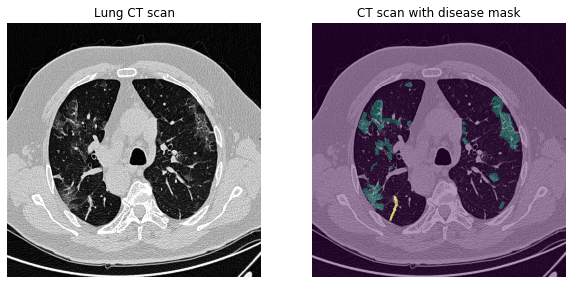

In [3]:
#using nibabel package 
images = nib.load('./tr_im.nii.gz')
masks = nib.load('./tr_mask.nii.gz')

# Get data dimensions 
img_header = images.header
mask_header = masks.header
print('Image dimensions:',img_header.get_data_shape())
print('Voxel Size:',img_header.get_zooms())
#print('Masks dimensions:',mask_header.get_data_shape())

#Print out representative images
lung_CT = images.get_fdata() # get's the image data in the form of an array 
mask = masks.get_fdata()
CT_slice = lung_CT[:,:,20]
mask_slice = mask[:,:,20]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Lung CT scan')
plt.imshow(ndimage.rotate(CT_slice,-90),cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('CT scan with disease mask')
plt.imshow(ndimage.rotate(CT_slice,-90),cmap='gray')
plt.imshow(ndimage.rotate(mask_slice,-90),alpha=0.4) # alpha value determines the opacity of 
plt.axis('off')



(-0.5, 511.5, 511.5, -0.5)

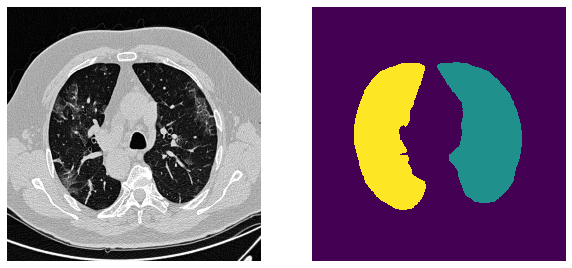

In [4]:
# Lung masks Load in image and plot ext to 
lungmask = nib.load('./tr_lungmasks_updated.nii.gz')
lung_mask = lungmask.get_fdata()
lung_slice = lung_mask[:,:,20]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(ndimage.rotate(CT_slice,-90),cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ndimage.rotate(lung_slice,-90))
plt.axis('off')

In [5]:
#Rotate the image datasets 
rotated_CT = ndimage.rotate(lung_CT,-90)
rotated_masks = ndimage.rotate(mask,-90) 
rotated_lm = ndimage.rotate(lung_mask,-90)


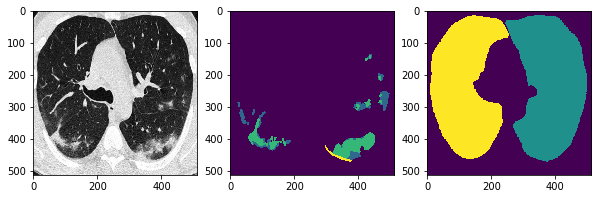

In [6]:
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(rotated_CT[:,:,10],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(rotated_masks[:,:,10])
plt.subplot(1,3,3)
plt.imshow(rotated_lm[:,:,10])


In [10]:
## Main code 
def path(string):
    if os.path.exists(string):
        return string
    else:
        sys.exit(f'File not found: {string}')

# creates a useful interface for command line use of the code when running the network 
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('input', metavar='input', type=path, help='Path to the input image, can be a folder for dicoms')
    parser.add_argument('output', metavar='output', type=str, help='Filepath for output lungmask')
    parser.add_argument('--modeltype', help='Default: unet', type=str, choices=['unet', 'resunet'], default='unet')
    parser.add_argument('--modelname', help="spcifies the trained model, Default: R231", type=str, choices=['R231','LTRCLobes','LTRCLobes_R231','R231CovidWeb'], default='R231')
    parser.add_argument('--cpu', help="Force using the CPU even when a GPU is available, will override batchsize to 1", action='store_true')
    parser.add_argument('--nopostprocess', help="Deactivates postprocessing (removal of unconnected components and hole filling", action='store_true')
    parser.add_argument('--batchsize', type=int, help="Number of slices processed simultaneously. Lower number requires less memory but may be slower.", default=20)

    argsin = sys.argv[1:]
    args = parser.parse_args(argsin)

    batchsize = args.batchsize
    if args.cpu:
        batchsize = 1

    logging.info(f'Load model')     # logging event
    model = mask.get_model(args.modeltype, args.modelname) # using inputs from argparser to call the model , default model is the R231, mask is imported as a package from lungmask
    input_image = utils.get_input_image(args.input)        # utils is in lungmasks and it just performs a function, in this it is getting the image from the input which is the path 
    logging.info(f'Infer lungmask')
    if modelname == 'LTRCLobes_R231':
        result = mask.apply_fused('LTRCLobes','R231') # uses the LTRCLobes as the base model and applying the mask 'fill model', so if you can use a hybrid model approach 
    else:
        result = mask.apply(input_image, model, force_cpu=args.cpu, batch_size=batchsize, volume_postprocessing=not(args.nopostprocess)) # if not you use r231 to do the whole task/ or whichver chosen 

    result_out = sitk.GetImageFromArray(result) # uses simple insight tool kit for wokrign with images in a dimension frame rather than images as arrays with pixels
    result_out.CopyInformation(input_image)
    logging.info(f'Save result to: {args.output}')
    sys.exit(sitk.WriteImage(result_out, args.output))


if __name__ == "__main__":
    print('called as script')
    main()

called as script


usage: ipykernel_launcher.py [-h] [--modeltype {unet,resunet}]
                             [--modelname {R231,LTRCLobes,LTRCLobes_R231,R231CovidWeb}]
                             [--cpu] [--nopostprocess] [--batchsize BATCHSIZE]
                             input output
ipykernel_launcher.py: error: the following arguments are required: output


SystemExit: 2

In [8]:
## Mask that is called later on, they built this to run in command line hence the argparse

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
warnings.filterwarnings("ignore", category=UserWarning)

# stores urls and number of classes of the models
model_urls = {('unet', 'R231'): ('https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth', 3),
              ('unet', 'LTRCLobes'): (
                  'https://github.com/JoHof/lungmask/releases/download/v0.0/unet_ltrclobes-3a07043d.pth', 6),
              ('unet', 'R231CovidWeb'): (
                  'https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231covid-0de78a7e.pth', 3)}

# applys the mask that is output from the model 
def apply(image, model=None, force_cpu=False, batch_size=20, volume_postprocessing=True):
    if model is None:
        model = get_model('unet', 'R231')  # if the commandline input is empty or not thtey use UNet r231

    voxvol = np.prod(image.GetSpacing())      # gets voxel volumes 
    inimg_raw = sitk.GetArrayFromImage(image)  # gets a numpy image from a sitk array 
    del image

    if force_cpu:
        device = torch.device('cpu')
    else:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            logging.info("No GPU support available, will use CPU. Note, that this is significantly slower!")
            batch_size = 1
            device = torch.device('cpu')
            
        
    model.to(device)       ##SENDS THE MODEL TO DEVICE THAT WAS DEFINED IN THE MAIN


    tvolslices, xnew_box = utils.preprocess(inimg_raw, resolution=[256, 256])   # see preprocessing in utils cell but it prepreocces the images before using the model 
    tvolslices[tvolslices > 600] = 600
    tvolslices = np.divide((tvolslices + 1024), 1624)
    torch_ds_val = utils.LungLabelsDS_inf(tvolslices)
    dataloader_val = torch.utils.data.DataLoader(torch_ds_val, batch_size=batch_size, shuffle=False, num_workers=1,
                                                 pin_memory=False)

    timage_res = np.empty((np.append(0, tvolslices[0].shape)), dtype=np.uint8)

    with torch.no_grad():                            # using no grad they sent the image array from teh dataloader and predicted the mask for that image
        for X in tqdm(dataloader_val):
            X = X.float().to(device)
            prediction = model(X)
            pls = torch.max(prediction, 1)[1].detach().cpu().numpy().astype(np.uint8)     # gets the max value of prediciton and does not consider the rest 
            timage_res = np.vstack((timage_res, pls))                                     # gets the output for that training image and uses a stack method to stack array for results and and pls

    # postprocessing includes removal of small connected components, hole filling and mapping of small components to
    # neighbors
    if volume_postprocessing:
        outmask = utils.postrocessing(timage_res)       # see post_processing in utils
    else:
        outmask = timage_res

    outmask = np.asarray(
        [utils.reshape_mask(outmask[i], xnew_box[i], inimg_raw.shape[1:]) for i in range(outmask.shape[0])],
        dtype=np.uint8)
                                                        # returns the outmask which is an array of the mask over the input region 
    return outmask

# function that gets the model specified by the user
def get_model(modeltype, modelname):
    model_url, n_classes = model_urls[(modeltype, modelname)] # uses URL of the data to pull the model and send it to the device being used 
    state_dict = torch.hub.load_state_dict_from_url(model_url, progress=True, map_location=torch.device('cpu'))
    if modeltype == 'unet':
        model = UNet(n_classes=n_classes, padding=True, depth=5, up_mode='upsample', batch_norm=True, residual=False)   # depending on the user specified type it calls that model which we load from  Unet coded
    elif modeltype == 'resunet':
        model = UNet(n_classes=n_classes, padding=True, depth=5, up_mode='upsample', batch_norm=True, residual=True)
    else:
        logging.exception(f"Model {modelname} not known")
    model.load_state_dict(state_dict)
    model.eval()
    return model


def apply_fused(image, basemodel = 'LTRCLobes', fillmodel = 'R231', force_cpu=False, batch_size=20, volume_postprocessing=True):   
    '''Will apply basemodel and use fillmodel to mitiage false negatives'''
    mdl_r = get_model('unet',fillmodel)
    mdl_l = get_model('unet',basemodel)
    res_l = apply(image, mdl_l, force_cpu=force_cpu, batch_size=batch_size,  volume_postprocessing=volume_postprocessing)
    res_r = apply(image, mdl_r, force_cpu=force_cpu, batch_size=batch_size,  volume_postprocessing=volume_postprocessing)
    spare_value = res_l.max()+1
    res_l[np.logical_and(res_l==0, res_r>0)] = spare_value
    res_l[res_r==0] = 0
    return utils.postrocessing(res_l, spare=[spare_value])


In [9]:
#ResUNet


class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv', residual=False):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
            residual: if True, residual connections will be added
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            if i == 0 and residual:
                self.down_path.append(UNetConvBlock(prev_channels, 2 ** (wf + i),
                                                    padding, batch_norm, residual, first=True))
            else:
                self.down_path.append(UNetConvBlock(prev_channels, 2 ** (wf + i),
                                                    padding, batch_norm, residual))
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode,
                                            padding, batch_norm, residual))
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        res = self.last(x)
        return self.softmax(res)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm, residual=False, first=False):
        super(UNetConvBlock, self).__init__()
        self.residual = residual
        self.out_size = out_size
        self.in_size = in_size
        self.batch_norm = batch_norm
        self.first = first
        self.residual_input_conv = nn.Conv2d(self.in_size, self.out_size, kernel_size=1)
        self.residual_batchnorm = nn.BatchNorm2d(self.out_size)

        if residual:
            padding = 1
        block = []

        if residual and not first:
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(in_size))

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))

        if not residual:
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        if self.residual:
            if self.in_size != self.out_size:
                x = self.residual_input_conv(x)
                x = self.residual_batchnorm(x)
            out = out + x

        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm, residual=False):
        super(UNetUpBlock, self).__init__()
        self.residual = residual
        self.in_size = in_size
        self.out_size = out_size
        self.residual_input_conv = nn.Conv2d(self.in_size, self.out_size, kernel_size=1)
        self.residual_batchnorm = nn.BatchNorm2d(self.out_size)

        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    @staticmethod
    def center_crop(layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out_orig = torch.cat([up, crop1], 1)
        out = self.conv_block(out_orig)
        if self.residual:
            if self.in_size != self.out_size:
                out_orig = self.residual_input_conv(out_orig)
                out_orig = self.residual_batchnorm(out_orig)
            out = out + out_orig

        return out

In [ ]:
## Utils
import scipy.ndimage as ndimage
import skimage.measure
import numpy as np
from torch.utils.data import Dataset
import os
import sys
import SimpleITK as sitk
import pydicom as pyd
import logging
from tqdm import tqdm
import fill_voids
import skimage.morphology


def preprocess(img, label=None, resolution=[192, 192]):
    imgmtx = np.copy(img)
    lblsmtx = np.copy(label)

    imgmtx[imgmtx < -1024] = -1024
    imgmtx[imgmtx > 600] = 600
    cip_xnew = []
    cip_box = []
    cip_mask = []
    for i in range(imgmtx.shape[0]):
        if label is None:
            (im, m, box) = crop_and_resize(imgmtx[i, :, :], width=resolution[0], height=resolution[1])
        else:
            (im, m, box) = crop_and_resize(imgmtx[i, :, :], mask=lblsmtx[i, :, :], width=resolution[0],
                                           height=resolution[1])
            cip_mask.append(m)
        cip_xnew.append(im)
        cip_box.append(box)
    if label is None:
        return np.asarray(cip_xnew), cip_box
    else:
        return np.asarray(cip_xnew), cip_box, np.asarray(cip_mask)


def simple_bodymask(img):
    maskthreshold = -500
    oshape = img.shape
    img = ndimage.zoom(img, 0.25, order=0)
    bodymask = img > maskthreshold
    bodymask = ndimage.binary_closing(bodymask)
    bodymask = ndimage.binary_fill_holes(bodymask, structure=np.ones((3, 3))).astype(int)
    bodymask = ndimage.binary_erosion(bodymask, iterations=2)
    bodymask = skimage.measure.label(bodymask.astype(int), connectivity=1)
    regions = skimage.measure.regionprops(bodymask.astype(int))
    if len(regions) > 0:
        max_region = np.argmax(list(map(lambda x: x.area, regions))) + 1
        bodymask = bodymask == max_region
        bodymask = ndimage.binary_dilation(bodymask, iterations=2)
    real_scaling = np.divide(oshape, img.shape)[0]
    return ndimage.zoom(bodymask, real_scaling, order=0)


def crop_and_resize(img, mask=None, width=192, height=192):
    bmask = simple_bodymask(img)
    #     img[bmask==0] = -1024 # this line removes background outside of the lung.
    # However, it has been shown problematic with narrow circular field of views that touch the lung.
    # Possibly doing more harm than help
    reg = skimage.measure.regionprops(skimage.measure.label(bmask))
    if len(reg) > 0:
        bbox = reg[0].bbox
    else:
        bbox = (0, 0, bmask.shape[0], bmask.shape[1])
    img = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    img = ndimage.zoom(img, np.asarray([width, height]) / np.asarray(img.shape), order=1)
    if not mask is None:
        mask = mask[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        mask = ndimage.zoom(mask, np.asarray([width, height]) / np.asarray(mask.shape), order=0)
        # mask = ndimage.binary_closing(mask,iterations=5)
    return img, mask, bbox


## For some reasons skimage.transform leads to edgy mask borders compared to ndimage.zoom
# def reshape_mask(mask, tbox, origsize):
#     res = np.ones(origsize) * 0
#     resize = [tbox[2] - tbox[0], tbox[3] - tbox[1]]
#     imgres = skimage.transform.resize(mask, resize, order=0, mode='constant', cval=0, anti_aliasing=False, preserve_range=True)
#     res[tbox[0]:tbox[2], tbox[1]:tbox[3]] = imgres
#     return res


def reshape_mask(mask, tbox, origsize):
    res = np.ones(origsize) * 0
    resize = [tbox[2] - tbox[0], tbox[3] - tbox[1]]
    imgres = ndimage.zoom(mask, resize / np.asarray(mask.shape), order=0)
    res[tbox[0]:tbox[2], tbox[1]:tbox[3]] = imgres
    return res


class LungLabelsDS_inf(Dataset):
    def __init__(self, ds):
        self.dataset = ds

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx, None, :, :].astype(np.float)


def read_dicoms(path, primary=True, original=True):
    allfnames = []
    for dir, _, fnames in os.walk(path):
        [allfnames.append(os.path.join(dir, fname)) for fname in fnames]

    dcm_header_info = []
    dcm_parameters = []
    unique_set = []  # need this because too often there are duplicates of dicom files with different names
    i = 0
    for fname in tqdm(allfnames):
        filename_ = os.path.splitext(os.path.split(fname)[1])
        i += 1
        if filename_[0] != 'DICOMDIR':
            try:
                dicom_header = pyd.dcmread(fname, defer_size=100, stop_before_pixels=True, force=True)
                if dicom_header is not None:
                    if 'ImageType' in dicom_header:
                        if primary:
                            is_primary = all([x in dicom_header.ImageType for x in ['PRIMARY']])
                        else:
                            is_primary = True

                        if original:
                            is_original = all([x in dicom_header.ImageType for x in ['ORIGINAL']])
                        else:
                            is_original = True

                        # if 'ConvolutionKernel' in dicom_header:
                        #     ck = dicom_header.ConvolutionKernel
                        # else:
                        #     ck = 'unknown'
                        if is_primary and is_original and 'LOCALIZER' not in dicom_header.ImageType:
                            h_info_wo_name = [dicom_header.StudyInstanceUID, dicom_header.SeriesInstanceUID,
                                              dicom_header.ImagePositionPatient]
                            h_info = [dicom_header.StudyInstanceUID, dicom_header.SeriesInstanceUID, fname,
                                      dicom_header.ImagePositionPatient]
                            if h_info_wo_name not in unique_set:
                                unique_set.append(h_info_wo_name)
                                dcm_header_info.append(h_info)
                                # kvp = None
                                # if 'KVP' in dicom_header:
                                #     kvp = dicom_header.KVP
                                # dcm_parameters.append([ck, kvp,dicom_header.SliceThickness])
            except:
                logging.error("Unexpected error:", sys.exc_info()[0])
                logging.warning("Doesn't seem to be DICOM, will be skipped: ", fname)

    conc = [x[1] for x in dcm_header_info]
    sidx = np.argsort(conc)
    conc = np.asarray(conc)[sidx]
    dcm_header_info = np.asarray(dcm_header_info)[sidx]
    # dcm_parameters = np.asarray(dcm_parameters)[sidx]
    vol_unique = np.unique(conc, return_index=1, return_inverse=1)  # unique volumes
    n_vol = len(vol_unique[1])
    logging.info('There are ' + str(n_vol) + ' volumes in the study')

    relevant_series = []
    relevant_volumes = []

    for i in range(len(vol_unique[1])):
        curr_vol = i
        info_idxs = np.where(vol_unique[2] == curr_vol)[0]
        vol_files = dcm_header_info[info_idxs, 2]
        positions = np.asarray([np.asarray(x[2]) for x in dcm_header_info[info_idxs, 3]])
        slicesort_idx = np.argsort(positions)
        vol_files = vol_files[slicesort_idx]
        relevant_series.append(vol_files)
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(vol_files)
        vol = reader.Execute()
        relevant_volumes.append(vol)

    return relevant_volumes


def get_input_image(path):
    if os.path.isfile(path):
        logging.info(f'Read input: {path}')
        input_image = sitk.ReadImage(path)
    else:
        logging.info(f'Looking for dicoms in {path}')
        dicom_vols = read_dicoms(path, original=False, primary=False)
        if len(dicom_vols) < 1:
            sys.exit('No dicoms found!')
        if len(dicom_vols) > 1:
            logging.warning("There are more than one volume in the path, will take the largest one")
        input_image = dicom_vols[np.argmax([np.prod(v.GetSize()) for v in dicom_vols], axis=0)]
    return input_image


def postrocessing(label_image, spare=[]):
    '''some post-processing mapping small label patches to the neighbout whith which they share the
        largest border. All connected components smaller than min_area will be removed
    '''

    # cleaning overall connected
    regionmask = skimage.measure.label(label_image > 0)
    regions = skimage.measure.regionprops(regionmask)
    resizes = np.asarray([x.area for x in regions])
    m = len(resizes)
    ix = np.zeros((m,), dtype=np.uint8)
    minsize = 0
    if m > 2:
        minsize = np.sort(resizes)[-3]
    ix[resizes > minsize] = 1
    ix = np.concatenate([[0, ], ix])
    cleaned = ix[regionmask]

    outmask = label_image
    outmask[cleaned == 0] = 0

    # merge small components to neighbours
    regionmask = skimage.measure.label(outmask)
    origlabels = np.unique(outmask)
    origlabels_maxsub = np.zeros((max(origlabels) + 1,), dtype=np.uint32)  # will hold the largest component for a label
    regions = skimage.measure.regionprops(regionmask, outmask)
    regions.sort(key=lambda x: x.area)
    regionlabels = [x.label for x in regions]

    # will hold mapping from regionlabels to original labels
    region_to_lobemap = np.zeros((len(regionlabels) + 1,), dtype=np.uint8)
    for r in regions:
        if r.area > origlabels_maxsub[r.max_intensity]:
            origlabels_maxsub[r.max_intensity] = r.area
            region_to_lobemap[r.label] = r.max_intensity

    for r in regions:
        if r.area < origlabels_maxsub[r.max_intensity] or region_to_lobemap[r.label] in spare:
            bb = bbox_3D(regionmask == r.label)
            sub = regionmask[bb[0]:bb[1], bb[2]:bb[3], bb[4]:bb[5]]
            dil = ndimage.binary_dilation(sub == r.label)
            neighbours, counts = np.unique(sub[dil], return_counts=True)
            mapto = r.label
            maxmap = 0
            myarea = 0
            for ix, n in enumerate(neighbours):
                if n != 0 and n != r.label and counts[ix] > maxmap:
                    maxmap = counts[ix]
                    mapto = n
                    myarea = r.area
            regionmask[regionmask == r.label] = mapto
            if regions[regionlabels.index(mapto)].area == origlabels_maxsub[
                regions[regionlabels.index(mapto)].max_intensity]:
                origlabels_maxsub[regions[regionlabels.index(mapto)].max_intensity] += myarea
            regions[regionlabels.index(mapto)].__dict__['_cache']['area'] += myarea

    outmask = region_to_lobemap[regionmask]

    if outmask.shape[0] == 1:
        # holefiller = lambda x: ndimage.morphology.binary_fill_holes(x[0])[None, :, :] # This is bad for slices that show the liver
        holefiller = lambda x: skimage.morphology.area_closing(x[0].astype(int), area_threshold=64)[None, :, :] == 1
    else:
        holefiller = fill_voids.fill

    for i in np.unique(outmask)[1:]:
        outmask[holefiller(outmask == i)] = i

    return outmask


def bbox_3D(labelmap, margin=2):
    shape = labelmap.shape
    r = np.any(labelmap, axis=(1, 2))
    c = np.any(labelmap, axis=(0, 2))
    z = np.any(labelmap, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    rmin -= margin if rmin >= margin else rmin
    rmax += margin if rmax <= shape[0] - margin else rmax
    cmin, cmax = np.where(c)[0][[0, -1]]
    cmin -= margin if cmin >= margin else cmin
    cmax += margin if cmax <= shape[1] - margin else cmax
    zmin, zmax = np.where(z)[0][[0, -1]]
    zmin -= margin if zmin >= margin else zmin
    zmax += margin if zmax <= shape[2] - margin else zmax

    return rmin, rmax, cmin, cmax, zmin, zmax
